In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from scipy.signal import find_peaks, convolve, medfilt
from scipy.optimize import curve_fit
import matplotlib as mpl
from glob import glob
from copy import copy
from natsort import natsorted

%matplotlib widget

In [2]:
# freqs, dark_s21 = np.load('./VNAsweep.npy')
freqs, dark_s21 = np.load('./S21s_20241018_11h28/S21_dark.npy')
M_pxs = 20
N_pxs = 20

In [3]:
sw = 3 # even number
mph = 0.15
window = np.ones(sw)/sw
smooth_s21 = convolve(dark_s21, window, mode='same')
ds21 = np.diff(smooth_s21, 1)
smooth_ds21 = convolve(ds21, window, mode='same')
d2s21 = np.diff(smooth_ds21, 1)

locs, props = find_peaks(d2s21, height=mph, prominence=mph)
heights = props['peak_heights']

locs += 1
f0s = freqs[locs]
s21_mins = smooth_s21[locs]
fig, ax = plt.subplot_mosaic('a;b', sharex=True, figsize=(12, 6), constrained_layout=True)
ax['a'].plot(freqs[:-2], d2s21, lw=.5)
ax['b'].plot(freqs, smooth_s21, lw=.5)
ax['a'].axhline(mph, c='r')

ax['a'].scatter(freqs[:-2][locs-1], heights, marker='v', c='None', edgecolor='g')
ax['b'].scatter(f0s, s21_mins, marker='^', c='None', edgecolor='g')
ax['b'].set_xlabel('Frequency [GHz]')
print(len(locs))

376


In [4]:
files = natsorted(glob('./S21s_20241018_11h28/*_*0.npy'))
print(files)
nr_steps = len(files)
nr_kids = len(locs)
sweeps = np.empty((nr_steps, len(freqs)))
smoothed_sweeps = np.empty((nr_steps, len(freqs)))
s21s = np.empty((nr_steps, nr_kids))
s21s[:] = np.nan
smooth_dark_s21 = convolve(dark_s21, window, mode='same')
s0 = s21_mins
for i, file in enumerate(files):
    f, s21 = np.load(file)
    sweeps[i, :] = s21
    smooth_s21 = convolve(s21, window, mode='same')
    smoothed_sweeps[i, :] = smooth_s21
    s21s[i, :]  = smooth_s21[locs] - s0 

['./S21s_20241018_11h28\\S21_x1y0.npy', './S21s_20241018_11h28\\S21_x2y0.npy', './S21s_20241018_11h28\\S21_x3y0.npy', './S21s_20241018_11h28\\S21_x4y0.npy', './S21s_20241018_11h28\\S21_x5y0.npy', './S21s_20241018_11h28\\S21_x6y0.npy', './S21s_20241018_11h28\\S21_x7y0.npy', './S21s_20241018_11h28\\S21_x8y0.npy', './S21s_20241018_11h28\\S21_x9y0.npy', './S21s_20241018_11h28\\S21_x10y0.npy', './S21s_20241018_11h28\\S21_x11y0.npy', './S21s_20241018_11h28\\S21_x12y0.npy', './S21s_20241018_11h28\\S21_x13y0.npy', './S21s_20241018_11h28\\S21_x14y0.npy', './S21s_20241018_11h28\\S21_x15y0.npy', './S21s_20241018_11h28\\S21_x16y0.npy', './S21s_20241018_11h28\\S21_x17y0.npy', './S21s_20241018_11h28\\S21_x18y0.npy', './S21s_20241018_11h28\\S21_x19y0.npy', './S21s_20241018_11h28\\S21_x20y0.npy']


In [16]:
s21s.shape

(20, 377)

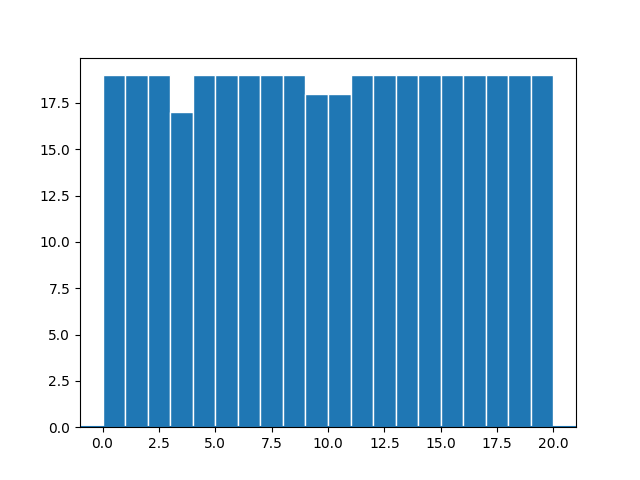

In [5]:
pos = np.empty((nr_kids, 4))
pos[:] = np.nan
pos[:, 0] = np.arange(nr_kids, dtype=int)
pos[:, 1] = locs
pos[:, 2] = f0s
for i in range(nr_kids):
    pos[i, 3] = np.nanargmax(s21s[:, i])
fig, ax = plt.subplots()
_ = ax.hist(pos[:, 3], bins=np.arange(nr_steps+1), facecolor='tab:blue', edgecolor='w')
ax.axhline()

In [6]:
add_doulbes = [(212, 3)]
for id, y in add_doulbes:
    pos = np.insert(pos, id, pos[id], axis=0)
    pos[id+1, 3] = y 
    pos[id:, 0] += 1
    f0s = np.insert(f0s, id, f0s[id])
    locs = np.insert(locs, id, locs[id])
    s21s = np.insert(s21s, id, s21s[:, id], axis=1)
    

In [7]:
fig, ax = plt.subplot_mosaic('ab', figsize=(12, 6), constrained_layout=True, sharey=True)   
ax['a'].scatter(pos[:, 2], pos[:, 3], c=pos[:, 3], cmap='viridis')
for i, txt in enumerate(pos[:, 0]):
    ax['a'].annotate(int(txt), (pos[i, 2], pos[i, 3]+.3), fontsize=8, ha='center', va='center', rotation=-90)
ax['b'].hist(pos[:, 3], bins=np.arange(nr_steps+1)-.5, facecolor='tab:blue', edgecolor='w', orientation='horizontal')
ax['b'].axvline(nr_steps-1, c='r', ls='--')
ax['b'].axvline(nr_steps, c='r')


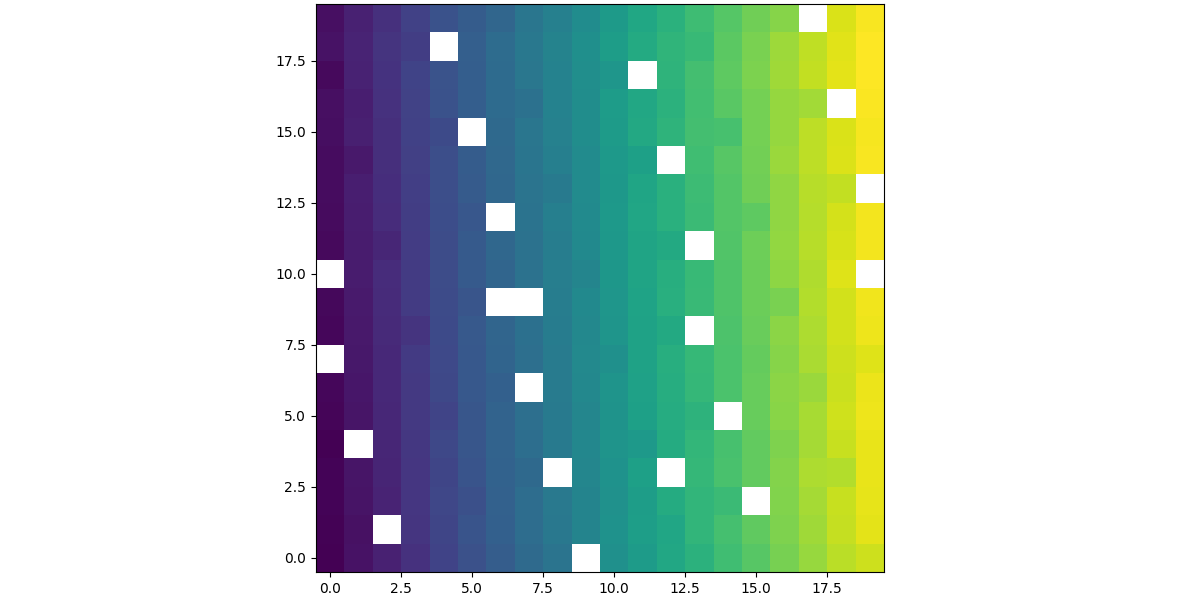

In [8]:
rows = [[] for _ in range(nr_steps)]
for i in pos:
    rows[int(i[-1])].append(int(i[0]))
kids_derolled = np.empty((M_pxs, N_pxs))
kids_derolled[:] = np.nan   
for i, row in enumerate(rows):
    kids_derolled[i, :len(row)] = row
kids_derolled
nans = [[0, 9], [1, 2], [2, 15], [3, 8], [3, 12], [4, 1], [5, 14], [6, 7], [7, 0], [8, 13], [9, 6], [9, 7], [10, 0], [10, 19], [11, 13], [12, 6], [13, 19], [14, 12], [15, 5], [16, 18], [17, 11], [18, 4], [19, 17]]
# nans = [[0, 9], [1, 2], [2, 15], [3, 8], [3, 11], [3, 12], [4, 1], [5, 14], [6, 7], [7, 0], [8, 13], [9, 6], [9, 7], [10, 0], [10, 19], [11, 13], [12, 6], [13, 19], [14, 12], [15, 5], [16, 18], [17, 11], [18, 4], [19, 17]]
for i, j in nans:
    kids_derolled[i, j+1:] = kids_derolled[i, j:-1]
    kids_derolled[i, j] = np.nan
kids_derolled

fig, ax = plt.subplot_mosaic('a', figsize=(12, 6), constrained_layout=True, sharey=True)   
ax['a'].imshow(kids_derolled, cmap='viridis', origin='lower')
# for i, txt in enumerate(pos[:, 0]):
#     ax['a'].annotate(int(txt), (pos[i, 2], pos[i, 3]+.3), fontsize=8, ha='center', va='center', rotation=-90)


In [9]:
# remove_kids = [345, 232]
# for i in remove_kids:
#     kids_derolled[kids_derolled == i] = np.nan
#     # s21s[:, i] = np.nan

In [10]:
kids = copy(kids_derolled)
for i, row in enumerate(kids_derolled):
    kids[i] = np.roll(row, i*7)
kids[~np.isnan(kids)] = kids[~np.isnan(kids)].astype(int)
kids
fig, ax = plt.subplot_mosaic('a', figsize=(12, 6), constrained_layout=True, sharey=True)   
ax['a'].imshow(kids, cmap='viridis', origin='lower')


In [11]:
kid_id_board = np.load('KID_ID_BOARD_20x20.npy').astype(int)
kid_id_board

array([[  0,  20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240,
        260, 280, 300, 320, 340, 360, 380],
       [261, 281, 301, 321, 341, 361, 381,   1,  21,  41,  61,  81, 101,
        121, 141, 161, 181, 201, 221, 241],
       [122, 142, 162, 182, 202, 222, 242, 262, 282, 302, 322, 342, 362,
        382,   2,  22,  42,  62,  82, 102],
       [383,   3,  23,  43,  63,  83, 103, 123, 143, 163, 183, 203, 223,
        243, 263, 283, 303, 323, 343, 363],
       [244, 264, 284, 304, 324, 344, 364, 384,   4,  24,  44,  64,  84,
        104, 124, 144, 164, 184, 204, 224],
       [105, 125, 145, 165, 185, 205, 225, 245, 265, 285, 305, 325, 345,
        365, 385,   5,  25,  45,  65,  85],
       [366, 386,   6,  26,  46,  66,  86, 106, 126, 146, 166, 186, 206,
        226, 246, 266, 286, 306, 326, 346],
       [227, 247, 267, 287, 307, 327, 347, 367, 387,   7,  27,  47,  67,
         87, 107, 127, 147, 167, 187, 207],
       [ 88, 108, 128, 148, 168, 188, 208, 228, 248, 268, 288, 3

In [12]:
design_f0s = np.load('LT361_4-8GHz_400px_F0s.npy')*1e-9
design_f0s_original = np.load('LT361_FAB_F0s.npy')*1e-9
design_f0s
dLk_Lk = (design_f0s - design_f0s_original)/design_f0s
fig, ax = plt.subplot_mosaic('ab', figsize=(6, 3), constrained_layout=True, sharex=True)
ax['a'].scatter(design_f0s_original, design_f0s, label='Lk62.3')
ax['a'].scatter(design_f0s_original, design_f0s_original, label='Lk64.9')
ax['a'].legend()

def func(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

popt, pcov = curve_fit(func, design_f0s_original, design_f0s)
y = func(design_f0s, *popt)
ax['a'].plot(design_f0s, y, c='r', ls='--')
dLk_Lk = (design_f0s_original - y)/design_f0s_original
ax['b'].scatter(design_f0s, dLk_Lk)
np.std(dLk_Lk)

6.121298724796853e-05

In [13]:
nanmask = np.isnan(kids)
design = design_f0s[kid_id_board[~nanmask]]
original = design_f0s_original[kid_id_board[~nanmask]]
meas = f0s[kids[~nanmask].astype(int)]
df_f = (design-meas) / design
print(np.std(df_f))

0.007642948113616251


In [14]:
# mask_left = np.zeros(len(design), dtype=bool)
# for i in range(len(design)):
#     x, y = np.where(kids==i)
#     if x<11:
#         mask_left[i] = 1
# mapleft = np.empty((M_pxs, N_pxs))
# mapleft[:] = np.nan
# mapleft[:, 11:] = 0
# mapright = np.zeros((M_pxs, N_pxs))
# mapright[:] = np.nan
# mapright[:, :11] = 0

C:\Users\wilbertr\AppData\Local\Temp\ipykernel_59732\3069121835.py:4: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if x<11:


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [26]:
def linear(x, a, b):
    return a*x+b

def secorder(x, a, b, c):
    return a*x**2+b*x

line = linear
popt, pcov = curve_fit(line, design.flatten(), meas.flatten())
meas_fit = line(design, *popt)
df_f_corr = (meas - meas_fit) / meas_fit
df_fmap = np.empty((M_pxs, N_pxs))
df_fmap[:] = np.nan
count = 0
for i, row in enumerate(kids):
    for j, k in enumerate(row):
        if ~np.isnan(k):
            df_fmap[i, j] = df_f_corr[count]
            count+=1
flim = np.array([np.min((design, meas)), np.max((design, meas))])

if line:
    if line == linear:
        eq = 'y=ax'
        save = 'fit_linear'
    elif line == secorder:
        eq = 'y=ax^2+bx'
        save = 'fit_secorder'
    print('line')
    popt, pcov = curve_fit(line, design.flatten(), meas.flatten())
    fit = line(design, *popt)
    xfit = np.linspace(flim[0], flim[1])
    yfit = line(xfit, *popt)
    label = 'y'
else:
    fit = design
    label = 'f_0^{design}'
    save = 'nofit'
size=20


fig, ax = plt.subplot_mosaic('abc', figsize=(16, 5), constrained_layout=True)
ax['a'].scatter(design, design, c='None', edgecolor='tab:blue', label='$\it f_0^{design}$')
ax['a'].scatter(design, meas, c='None', edgecolor='tab:orange', label='$\it f_0^{design}$')
ax['a'].scatter(design, original, c='None', edgecolor='tab:gray', label='$\it f_0^{original}$')
if line:
    ax['a'].plot(xfit, yfit, c='k', label='fit: $%s$' % eq, ls='--', lw=0.5)
ax['a'].set_xlabel('$\it f_0^{design}$ $[GHz]$')
ax['a'].set_ylabel('$\it f_0$ $[GHz]$')
ax['a'].set_xlim(flim)
ax['a'].set_ylim(flim)
ax['a'].legend(loc='upper left')
ax['b'].scatter(design, df_f_corr, c=df_f_corr, label='residual, $f_0-y_2$')
# for i, x in enumerate(design):
#     ax['b'].annotate(i, (x, df_f_corr[i]), fontsize=8, ha='center', va='center')
ax['b'].annotate
ax['b'].set_ylabel('$\it (f_0^{meas}-%s)/%s$' % (label, label))
ax['b'].set_xlabel('$\it f_0^{design}$ $[GHz]$')
im = ax['c'].imshow(df_fmap, cmap='viridis', origin='lower')
# for i, x in enumerate(df_fmap):
#     for j, y in enumerate(x):
#         if ~np.isnan(y):
#             old_id = kid_id_board[i, j]
#             new_id = kids[i, j]
#             if old_id == new_id:
#                 c = 'w'
#             else:
#                 c = 'r'
#             ax['c'].text(j, i, '%d' % new_id, ha='center', va='center', fontsize=6, color=c)
# Major ticks
ax['c'].set_xticks(np.arange(0, size, 1));
ax['c'].set_yticks(np.arange(0, size, 1));
# Labels for major ticks
ax['c'].set_xticklabels(np.arange(1, size+1, 1));
ax['c'].set_yticklabels(np.arange(1, size+1, 1));
# labels
ax['c'].set_xlabel('$\it x$ $[px]$')
ax['c'].set_ylabel('$\it y$ $[px]$')
cbar = fig.colorbar(im, ax=ax['c'])
# cbar.ax.invert_yaxis()
_ = cbar.ax.set_ylabel('$\it (f_0^{meas}-%s)/%s$' % (label, label))
# _ = cbar.ax.set_ylabel('$\it (f_0^{meas}-%s)/%s$' % (label, label))


line


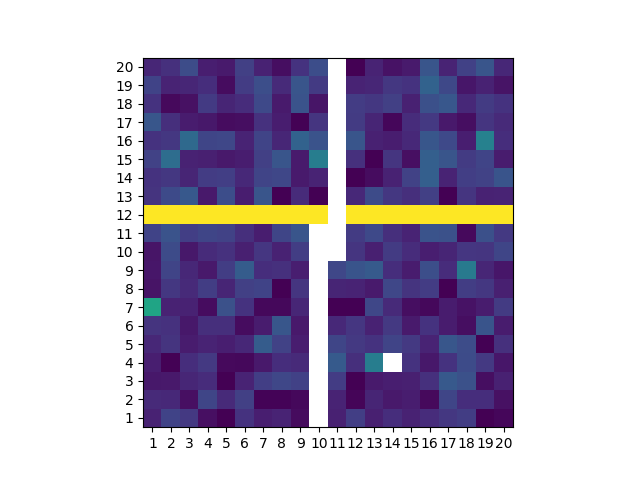

In [101]:
nr_scans = 20

def map():
    maps = np.zeros((M_pxs, N_pxs, nr_scans))
    for nr in range(nr_scans):
        for i, m in enumerate(kids):
            for j, k in enumerate(m):
                if ~np.isnan(k):
                    k = int(k)
                    s21s[:, k] -= np.amin(s21s[:, k])
                    s21s[:, k] /= np.amax(s21s[:, k])
                    maps[i, j, nr] = s21s[nr, int(k)]
                else:
                    maps[i, j, nr] = np.nan
    return maps
maps = map()
fig, ax = plt.subplots()
ax.imshow(maps[:, :, 11], origin='lower', cmap='viridis')
ax.set_xticks(np.arange(0, size, 1));
ax.set_yticks(np.arange(0, size, 1));
# Labels for major ticks
ax.set_xticklabels(np.arange(1, size+1, 1));
ax.set_yticklabels(np.arange(1, size+1, 1));

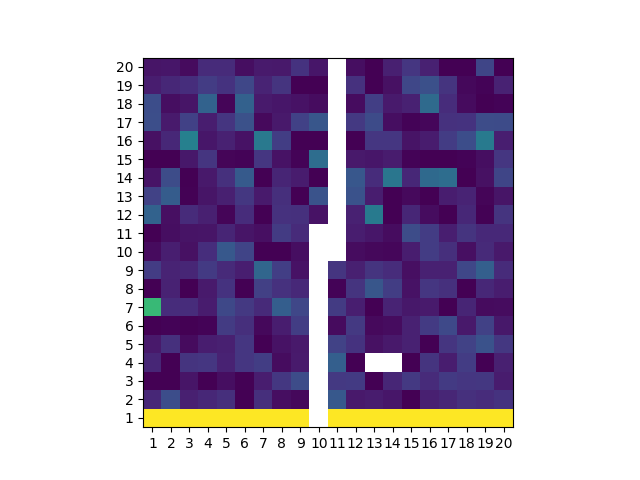

MovieWriter Pillow unavailable; using Pillow instead.


In [23]:
import matplotlib.animation as animation

fig, ax = plt.subplots()
cax = ax.imshow(maps[:, :, 0], origin='lower', cmap='viridis')
ax.set_xticks(np.arange(0, size, 1));
ax.set_yticks(np.arange(0, size, 1));
# Labels for major ticks
ax.set_xticklabels(np.arange(1, size+1, 1));
ax.set_yticklabels(np.arange(1, size+1, 1));

def update(frame):
    cax.set_array(maps[:, :, frame])
    return cax,
ani = animation.FuncAnimation(fig, update, frames=nr_scans, interval=200, blit=True)
plt.show()
ani.save('animation_before.gif', writer='Pillow')

In [ ]:
# 346 at (1, 7) not response
# 233 at (8, 6) not response
# 212 at (10, 15) has a double peak at 3 and 14, add to 3

In [21]:
ids = np.arange(376, dtype=int)
ids = [212]
fig, ax = plt.subplot_mosaic('ba', figsize=(12, 4), constrained_layout=True)
start = 0
stop = 20
# steps = np.arange(start, stop)
steps = [3, 6, 14]
bw = 25
colors = plt.cm.viridis(np.linspace(0, 1, len(steps)))
for id in ids:
    res = f0s[id]
    loc = locs[id]
    ax['a'].plot(freqs[loc-bw:loc+bw], smooth_dark_s21[loc-bw:loc+bw], lw=1, c='k', label='dark')
    ax['a'].axvline(res, c='k', ls='--', lw=.5)
    for i, step in enumerate(steps):
        ax['a'].plot(freqs[loc-bw:loc+bw], smoothed_sweeps[step, loc-bw:loc+bw], lw=1, label=str(step), c=colors[i])
        ax['b'].axvline(step, ls='--', lw=.5, c=colors[i])
    ax['b'].plot(s21s[:, id], lw=.5, label=str(id))
ax['b'].legend()
ax['a'].legend()